# Tensorflow and Keras model
## Imports and version check

In [37]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(tf.test.is_built_with_cuda())

2.6.0
True


## Configuration

In [20]:
plt.style.use("ggplot")
np.set_printoptions(precision=3, suppress=True)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Read CSV file

In [39]:
# current_path = os.path.dirname(os.path.realpath(__file__))
current_path = os.path.abspath('')
training_data_path = os.path.abspath(os.path.join(current_path, '..', '..', 'data', 'TRAINING_DATA_FIRST_1000.csv'))
csv_data = pd.read_csv(training_data_path)
csv_data.head()

,1,2,3,4,5,6,7,8,9,10,...,keff64,keff65,keff66,keff67,keff68,keff69,ppf_start,ppf_max,ppf_end,cycle_length_in_days
0,8,2,7,3,2,5,2,1,6,6,...,0.945909,0.944285,0.942662,0.941040,0.939418,0.937797,4.433,5.608,1.381,411.474034
1,6,4,4,9,9,9,1,3,6,7,...,0.952956,0.951327,0.949698,0.948070,0.946443,0.944816,2.690,2.690,1.320,432.732046
2,4,7,6,8,4,5,9,2,6,8,...,0.951664,0.950032,0.948401,0.946772,0.945143,0.943517,4.269,5.356,1.324,429.459459
3,4,7,2,6,1,5,1,6,4,4,...,0.947787,0.946196,0.944604,0.943012,0.941420,0.939828,5.760,7.038,1.422,409.351467
4,7,9,9,9,4,6,7,4,9,9,...,0.947005,0.945420,0.943835,0.942251,0.940666,0.939082,2.572,2.572,1.424,408.764331


Split data into train and test

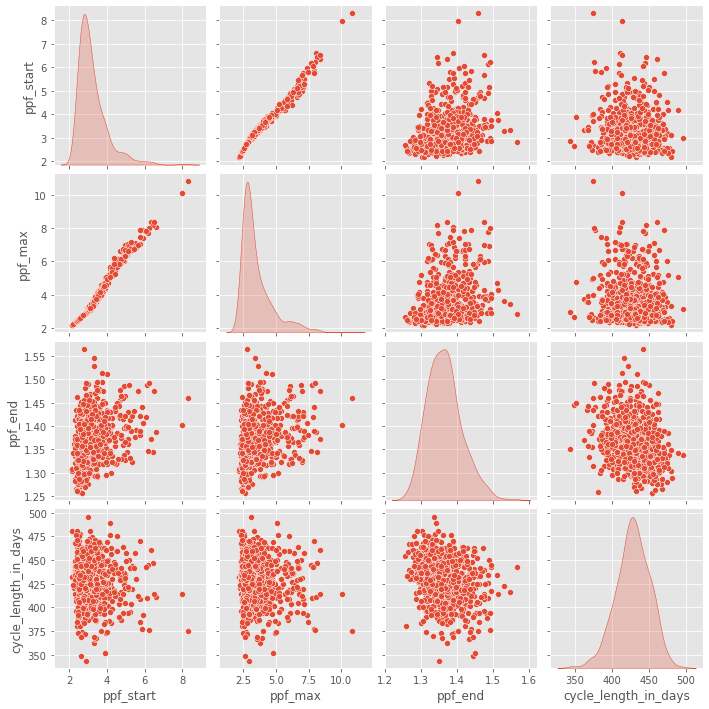

In [40]:
dataset = csv_data.copy()
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

sns.pairplot(train_dataset[['ppf_start', 'ppf_max', 'ppf_end', 'cycle_length_in_days']], diag_kind='kde')